In [46]:
# Link para base do projeto:
# https://www.kaggle.com/code/akshayarajasekaran/cd-sentiment-analysis-of-tweets/data

# Link drive professor:
# https://drive.google.com/drive/folders/1idNpDd9aEE2j5w7Uc9Tja92ekRIt8hKd?usp=sharing

---  
## Pacotes e bibliotecas

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

import nltk
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

---  
## Funções

In [2]:
def text_preprocessing(string, keep_stop=False, keep_num=True, min_len=1):
    string = str(string)
    string = string.lower()
    tokens = word_tokenize(string)
    if keep_num:
        words = [word for word in tokens if  word.isalnum() ]
    else:
        words = [word for word in tokens if  word.isalpha() ]
    if not keep_stop:
        sw_en = set(stopwords.words('english'))
        words_clean = [word for word in words if word not in sw_en and len(word)>=min_len]
    else:
        words_clean = [word for word in words if len(word)>=min_len]
    return words_clean

def text_stem(string, keep_stop=False, keep_num=True, min_len=1):
    stemmer = PorterStemmer()
    tokens = text_preprocessing(string, keep_stop, keep_num, min_len)
    words_stem = [stemmer.stem(word) for word in tokens]
    return words_stem

def text_lemma(string, keep_stop=False, keep_num=True, min_len=1):
    lemmatizer = WordNetLemmatizer()
    tokens = text_preprocessing(string, keep_stop, keep_num, min_len)
    words_lemma = [lemmatizer.lemmatize(word) for word in tokens]
    return words_lemma

In [3]:
def run_models_get_results(models, X_train, y_train):

    results = {}
    t = datetime.now()

    for alg, clf in models.items():
        t0 = datetime.now()
        clf.fit(X_train, y_train) 
        t1 = datetime.now()
        results[alg] = clf.cv_results_
        print(f"Algorítmo treinado: {alg}\t Duração: {t1-t0}")

    print(f"\nTempo total: {t1-t}")
    results = pd.DataFrame.from_dict(results)

    return results

In [66]:
def get_best_param_each_score(results):
    best_param_each_score = {}
    for indice in [x for x in results.index if 'rank_test_' in x]:
        best_each = [x[0]-1 for x in results.loc[indice]]
        best_param_each_score[indice]= [ x[best_each[i]] for i,x in enumerate(results.loc['params'])]
    text=''
    for key, value in best_param_each_score.items():
        text+= ' > ' + str(key) + '\n   ' + '\n   '.join([str(x) for x in value]) + '\n\n'
    return text


def get_mean_test_each_score(results, score):
    mean_test_each_score = {}
    for scr in score:
        for indice in [x for x in results.index if scr in x and "mean_test_" in x]:
            best_each = [x[0]-1 for x in results.loc['rank_test_'+scr]]
            mean_test_each_score[indice]= [ x[best_each[i]] for i,x in enumerate(results.loc[indice])]
    return mean_test_each_score


def get_best_score_each_model(results, score):
    best_score_each_model={}
    for scr in score:
        for indice in [x for x in results.index if scr in x and "split" in x]:
            best_each = [x[0]-1 for x in results.loc['rank_test_'+scr]]
            best_score_each_model[indice]= [ x[best_each[i]] for i,x in enumerate(results.loc[indice])]
    df_best_score_each_model = pd.DataFrame(best_score_each_model).transpose()
    df_best_score_each_model.columns = results.columns
    return df_best_score_each_model


def make_compare_charts(best_score_each_model, best_param_each_score, mean_test_each_score, score, gscv, n_models):
    f, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)  

    print('>> Best Params', '='*100)
    print(best_param_each_score)
    for idx, scr in enumerate(score):
        linhas = [x for x in best_score_each_model.index if scr in x]
        box_df = best_score_each_model.loc[linhas]
        axes[idx].boxplot([ scores for alg, scores in box_df.iteritems() ])
        axes[idx].set_xticklabels(box_df.columns)
        [axes[idx].axhline( x, color="gray", linestyle=':') for x in mean_test_each_score['mean_test_'+scr]]
        [axes[idx].text(0.53, x, box_df.columns[i], color='gray') for i,x in enumerate(mean_test_each_score['mean_test_'+scr])]
        [axes[idx].text(n_models+0.5, x, f'{x:.2f}', color="gray") for x in mean_test_each_score['mean_test_'+scr]]
        #axes[idx].text(0.5, 1, "mean", color='gray')
        axes[idx].set_title(scr)
        #label = best_param_each_score['rank_test_'+scr]
        #print('>>', scr)

    print('>> Charts', '='*100)
    print(f'   Results from Cross Validation with {gscv.get_n_splits()} folds.')
    plt.tight_layout()
    plt.show()


def compare_model_score(results, score, gscv, n_models):
    best_param_each_score = get_best_param_each_score(results)
    mean_test_each_score = get_mean_test_each_score(results, score)
    best_score_each_model = get_best_score_each_model(results, score)
    make_compare_charts(score=score, gscv=gscv, n_models=n_models,
                        best_param_each_score=best_param_each_score,
                        best_score_each_model=best_score_each_model,
                        mean_test_each_score=mean_test_each_score)


In [5]:
emojis = {':)': 'smile',
          '(:': 'smile',
          ':-)': 'smile',
          '=)': 'smile',
          '(=': 'smile',
          ':^)': 'smile',
          '=^)': 'smile',
          '=D': 'joy',
          ':D': 'joy',
          ':-D': 'joy',
          'XD': 'joy',
          ':(': 'sad', 
          '):': 'sad',
          ':-(': 'sad',
          ':-<': 'sad',
          ':-(': 'sad',
          '=(': 'sad',
          ')=': 'sad',
          ':^(': 'sad',
          '=^(': 'sad',
          ":'-)": 'sadsmile',
          "TT": 'crying',
          "T-T": 'crying',
          "T.T": 'crying',
          "(T.T)": 'crying',
          ';d': 'wink',
          ';)': 'wink',
          ';D': 'wink',
          ';-)': 'wink',
          ':-E': 'vampire',
          ':P': 'raspberry',
          ':-@': 'shocked',
          ':@': 'shocked',
          ':\\': 'annoyed', 
          ':#': 'mute',
          ':X': 'mute',
          ':-$': 'confused',
          ':-&': 'confused',
          ':-!': 'confused',
          ':O': 'surprised',
          'O.o': 'surprised',
          'O.O': 'surprised',
          'o.O': 'surprised',
          '@@': 'surprised',
          '$_$': 'greedy',
          '$.$': 'greedy',
          ':-0': 'yell',
          '<(-_-)>': 'robot',
          'd[-_-]b': 'dj',
          'O:-)': 'angel',
          'O*-)': 'angel',
          '(:-D': 'gossip',
          '=^.^=': 'cat'
          }

---  
## Importando dados

In [61]:
data_cols  = ["sentiment", "ids", "date", "flag", "user", "text"]
data_encoding = "ISO-8859-1"

tweets = pd.read_csv('data/tweets_dataset.csv', encoding=data_encoding, names=data_cols)
tweets.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


---  
## Análise exploratória

In [62]:
tweets.duplicated().sum()

0

In [63]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [64]:
# Nenhum registro duplicado.
# Aparentemente, nenhum valor nulo.
# ids pode ser deletado
tweets = tweets.drop(columns=['ids', 'flag'])

In [65]:
for col in tweets.columns:
    print(col.upper())
    print(tweets[col].value_counts(), '\n')

SENTIMENT
0    800000
4    800000
Name: sentiment, dtype: int64 

DATE
Mon Jun 15 12:53:14 PDT 2009    20
Fri May 29 13:40:04 PDT 2009    17
Fri May 22 05:10:17 PDT 2009    17
Mon Jun 15 13:39:50 PDT 2009    17
Fri Jun 05 14:13:07 PDT 2009    16
                                ..
Sun Jun 07 12:36:07 PDT 2009     1
Sun Jun 07 12:36:04 PDT 2009     1
Sun Jun 07 12:36:03 PDT 2009     1
Sun Jun 07 12:36:02 PDT 2009     1
Tue Jun 16 08:40:50 PDT 2009     1
Name: date, Length: 774363, dtype: int64 

USER
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
67trinity            1
Sibby                1
mAnyA_15             1
49ersfan111          1
bpbabe               1
Name: user, Length: 659775, dtype: int64 

TEXT
isPlayer Has Died! Sorry                                                                              210
good morning                                                                             

In [66]:
# dataset com output balanceado

# alguns usuários com uma freqência de postagem bem maior
# alguns textos, mesmo ainda sem tratamento, também com maior freq

# manter, por enquanto, usuário para depois tentar fazer algumas análises se alguns são mais positivos/negativos que outros
# manter a data também para depois tentar fazer análise se positivo/negativo teve um período específico

In [67]:
# tratando a data
tweets['date'] = pd.to_datetime(tweets['date'], errors='coerce')
tweets['date'].head()

c:\Users\mmm_n\AppData\Local\Programs\Python\Python39\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


0   2009-04-06 22:19:45
1   2009-04-06 22:19:49
2   2009-04-06 22:19:53
3   2009-04-06 22:19:57
4   2009-04-06 22:19:57
Name: date, dtype: datetime64[ns]

In [68]:
# verificando de que período são os tweets
print(f'max date: {tweets.date.max()} \nmin date: {tweets.date.min()}')

max date: 2009-06-25 10:28:31 
min date: 2009-04-06 22:19:45


In [69]:
# Verificar se houve algum dia ou horário onde tiveram mais mensagens
tweets['day'] = tweets['date'].dt.date
tweets['hour'] = tweets['date'].dt.hour

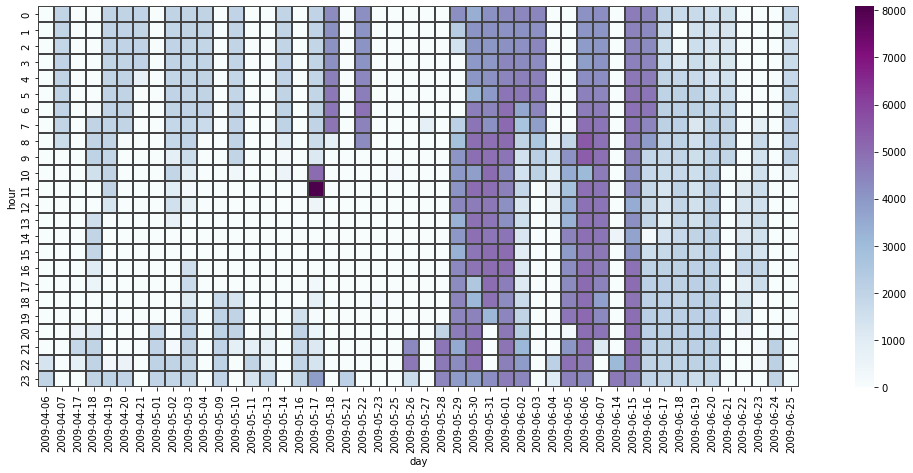

In [70]:
# plotando o heatmap com quantidade de tweet por hora e dia -----------------------------------------------------
day_by_hour_heatmap = tweets.pivot_table(columns='day', index='hour', values='sentiment', aggfunc='count', fill_value=0)

plt.figure(figsize=(20,7))
sns.heatmap(day_by_hour_heatmap, cmap="BuPu", square=True, annot=False, fmt=',.0f',
                linewidth=0.01, linecolor="#444", cbar=True,
                vmin=day_by_hour_heatmap.min().min(), vmax=day_by_hour_heatmap.max().max())
plt.show();

In [71]:
# tem um período específico que há uma maior quantidade de tweets
# entre dias 28/maio e 16/junho
# há um ponto interessante no dia 17/maio, entre 10h e 11h da manhã

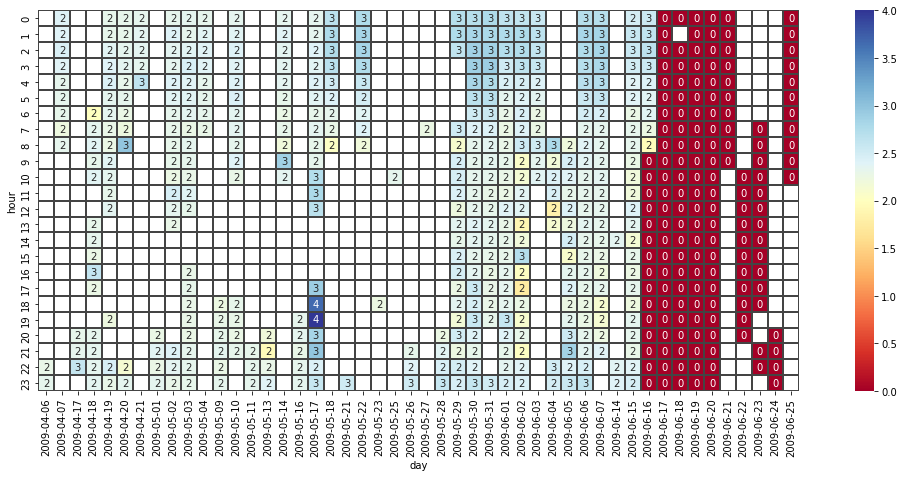

In [72]:
# plotando o heatmap por hora e dia verificando se houve algum momento mais positivo ou negativo ---------------
# lembrando que: 0 = Negative, 4 = Positive
day_by_hour_heatmap = tweets.pivot_table(columns='day', index='hour', values='sentiment', aggfunc='mean', fill_value=None)

plt.figure(figsize=(20,7))
sns.heatmap(day_by_hour_heatmap, cmap="RdYlBu", square=True, annot=True, fmt=',.0f',
                linewidth=0.01, linecolor="#444", cbar=True,
                vmin=day_by_hour_heatmap.min().min(), vmax=day_by_hour_heatmap.max().max())
plt.show();

In [73]:
# tem um período específico que houve muitos teewts negativos
# entre dias 16/junho e 25/junho
# há um ponto interessante no dia 17/maio, entre 10h e 12h da manhã  e  entre 18h e 21h, onde são bem positivos

In [74]:
# criando um cópia para continuidade dos tratamentos e análises
tweets_2 = tweets.copy()

---  
## Tratamento dos textos

In [75]:
# contando quantas menções de outros usuários há no texto
ment_pattern = r'(?!\b)@([a-zA-Z0-9_]{1,15})'
tweets_2['mentions_qty'] = tweets_2['text'].apply(lambda x: re.subn(ment_pattern, '', x)[1])

# contando quantos hastags tem no texto
hash_pattern = r'(\#[a-zA-Z0-9_%]*)'
tweets_2['hashtag_qty'] = tweets_2['text'].apply(lambda x: re.subn(hash_pattern, '', x)[1])

# contando quantos sites tem no texto
site_pattern = r'(https?:\/\/)?(www\.)[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)|(https?:\/\/)?(www\.)?(?!ww)[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)'
tweets_2['site_qty'] = tweets_2['text'].apply(lambda x: re.subn(site_pattern, '', x)[1])

In [76]:
# criando nova cópia
tweets_3 = tweets_2.copy()

In [77]:
# transformando tudo para minúscula
tweets_3['text'] = tweets_3['text'].apply(lambda x: x.lower())

# substituindo endereçso de sites por 'URL'
tweets_3['text'] = tweets_3['text'].apply(lambda x: re.sub(site_pattern, 'URL', x))

# substituindo menções por 'USER'
tweets_3['text'] = tweets_3['text'].apply(lambda x: re.sub(ment_pattern, 'USER', x))

# substituindo emojis por pelas descrições atreladas
for emoji in emojis.keys():
    tweets_3['text'] = tweets_3['text'].apply(lambda x: x.replace(emoji, emojis[emoji]))

# tamanho dos textos
tweets_3['len'] = tweets_3['text'].apply(lambda x: len(x))

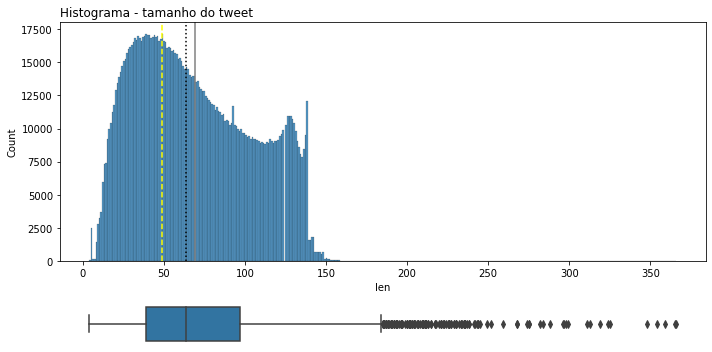

In [78]:
# vendo tamanho dos tweets
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5), gridspec_kw={"height_ratios": (.85, .15)})

sns.histplot(data=tweets_3, x='len', ax=axes[0]) 
sns.boxplot(data=tweets_3, x='len', ax=axes[1])

axes[0].set_title("Histograma - tamanho do tweet", loc='left')
axes[0].axvline(tweets_3['len'].mean(), color="gray", linestyle='-')
axes[0].axvline(tweets_3['len'].median(), color="black", linestyle=':')
axes[0].axvline(tweets_3['len'].mode()[0], color="yellow", linestyle='--')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [79]:
tweets_3[tweets_3['len']<7].text.value_counts()

USER      2493
USER       113
URL         89
USER:        9
URL          8
URL!         8
 USER        8
URL          3
USER,        2
 URL         2
 URL         1
ouch         1
 just        1
ugh          1
 URL !       1
URL!!        1
USER.        1
i URL        1
URL  x       1
USER!        1
hey          1
yes          1
and*         1
 URL!        1
Name: text, dtype: int64

---  
## Tokens, Lemma, Stem & Bigrams

In [81]:
# como nesta época a capacidade do tweet era de 140 caracteres, excluindo linhas com mais de 140
tweets_4 = tweets_3[tweets_3['len']<=140]
tweets_4.drop(columns=['date', 'user', 'day', 'hour'], inplace=True)

C:\Users\mmm_n\AppData\Local\Temp/ipykernel_13924/3780681208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_4.drop(columns=['date', 'user', 'day', 'hour'], inplace=True)


In [82]:
# salvando o arquivo tratado até o momento para não precisar executar todo código na próxima vez
# tweets_4.to_csv('data/tweets_4.csv', header=True, index=False)

# carregando arquivo salvo
#tweets_4 = pd.read_csv('data/tweets_4.csv')
#tweets_4.head()

In [83]:
tweets_4.shape

(1590916, 6)

In [84]:
tweets_4.head()

,sentiment,text,mentions_qty,hashtag_qty,site_qty,len
0,0,"USER URL - awww, that's a bummer. you shoulda...",1,0,1,89
1,0,is upset that he can't update his facebook by ...,0,0,0,111
2,0,USER i dived many times for the ball. managed ...,1,0,0,84
3,0,my whole body feels itchy and like its on fire,0,0,0,47
4,0,"USER no, it's not behaving at all. i'm mad. wh...",1,0,0,99


In [85]:
# tratamentos iniciais ---------------------------------------------------------------------------------------------------------
tweets_4['tokens_with_stop'] = tweets_4['text'].apply(lambda x: text_preprocessing(x, keep_stop=True, keep_num=True, min_len=3)) 
tweets_4['tokens_no_stop'] = tweets_4['text'].apply(lambda x: text_preprocessing(x, keep_stop=False, keep_num=False, min_len=3)) 
tweets_4['stem_words'] = tweets_4['text'].apply(lambda x: text_stem(x, keep_stop=False, keep_num=False, min_len=3)) 
tweets_4['lemma_words'] = tweets_4['text'].apply(lambda x: text_lemma(x, keep_stop=False, keep_num=False, min_len=3)) 

# criando srings para modelo----------------------------------------------------------------------------------------------------
tweets_4['token_string'] = tweets_4['tokens_no_stop'].apply(lambda x: ' '.join(x))
tweets_4['stem_string'] = tweets_4['stem_words'].apply(lambda x: ' '.join(x))
tweets_4['lemma_string'] = tweets_4['lemma_words'].apply(lambda x: ' '.join(x))

# bigramas para análise de freq ------------------------------------------------------------------------------------------------
tweets_4['token_bigram'] = tweets_4['tokens_no_stop'].apply(lambda x: list(ngrams(x, 2)))
tweets_4['stem_bigram'] = tweets_4['stem_words'].apply(lambda x: list(ngrams(x, 2)))
tweets_4['lemma_bigram'] = tweets_4['lemma_words'].apply(lambda x: list(ngrams(x, 2)))

tweets_4.head()

C:\Users\mmm_n\AppData\Local\Temp/ipykernel_13924/3314117223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_4['tokens_with_stop'] = tweets_4['text'].apply(lambda x: text_preprocessing(x, keep_stop=True, keep_num=True, min_len=3))
C:\Users\mmm_n\AppData\Local\Temp/ipykernel_13924/3314117223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_4['tokens_no_stop'] = tweets_4['text'].apply(lambda x: text_preprocessing(x, keep_stop=False, keep_num=False, min_len=3))
C:\Users\mmm_n\AppData\Local

,sentiment,text,mentions_qty,hashtag_qty,site_qty,len,tokens_with_stop,tokens_no_stop,stem_words,lemma_words,token_string,stem_string,lemma_string,token_bigram,stem_bigram,lemma_bigram
0,0,"USER URL - awww, that's a bummer. you shoulda...",1,0,1,89,"[user, url, awww, that, bummer, you, shoulda, ...","[user, url, awww, bummer, shoulda, got, david,...","[user, url, awww, bummer, shoulda, got, david,...","[user, url, awww, bummer, shoulda, got, david,...",user url awww bummer shoulda got david carr th...,user url awww bummer shoulda got david carr th...,user url awww bummer shoulda got david carr th...,"[(user, url), (url, awww), (awww, bummer), (bu...","[(user, url), (url, awww), (awww, bummer), (bu...","[(user, url), (url, awww), (awww, bummer), (bu..."
1,0,is upset that he can't update his facebook by ...,0,0,0,111,"[upset, that, update, his, facebook, texting, ...","[upset, update, facebook, texting, might, cry,...","[upset, updat, facebook, text, might, cri, res...","[upset, update, facebook, texting, might, cry,...",upset update facebook texting might cry result...,upset updat facebook text might cri result sch...,upset update facebook texting might cry result...,"[(upset, update), (update, facebook), (faceboo...","[(upset, updat), (updat, facebook), (facebook,...","[(upset, update), (update, facebook), (faceboo..."
2,0,USER i dived many times for the ball. managed ...,1,0,0,84,"[user, dived, many, times, for, the, ball, man...","[user, dived, many, times, ball, managed, save...","[user, dive, mani, time, ball, manag, save, re...","[user, dived, many, time, ball, managed, save,...",user dived many times ball managed save rest b...,user dive mani time ball manag save rest bound,user dived many time ball managed save rest bound,"[(user, dived), (dived, many), (many, times), ...","[(user, dive), (dive, mani), (mani, time), (ti...","[(user, dived), (dived, many), (many, time), (..."
3,0,my whole body feels itchy and like its on fire,0,0,0,47,"[whole, body, feels, itchy, and, like, its, fire]","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]","[whole, body, feel, itchy, like, fire]",whole body feels itchy like fire,whole bodi feel itchi like fire,whole body feel itchy like fire,"[(whole, body), (body, feels), (feels, itchy),...","[(whole, bodi), (bodi, feel), (feel, itchi), (...","[(whole, body), (body, feel), (feel, itchy), (..."
4,0,"USER no, it's not behaving at all. i'm mad. wh...",1,0,0,99,"[user, not, behaving, all, mad, why, here, bec...","[user, behaving, mad, see]","[user, behav, mad, see]","[user, behaving, mad, see]",user behaving mad see,user behav mad see,user behaving mad see,"[(user, behaving), (behaving, mad), (mad, see)]","[(user, behav), (behav, mad), (mad, see)]","[(user, behaving), (behaving, mad), (mad, see)]"


In [86]:
tweets_4.isnull().sum()

sentiment           0
text                0
mentions_qty        0
hashtag_qty         0
site_qty            0
len                 0
tokens_with_stop    0
tokens_no_stop      0
stem_words          0
lemma_words         0
token_string        0
stem_string         0
lemma_string        0
token_bigram        0
stem_bigram         0
lemma_bigram        0
dtype: int64

In [87]:
# salvando o arquivo tratado até o momento para não precisar executar todo código na próxima vez
tweets_4.to_csv('data/tweets_4_1.csv', header=True, index=False)

# carregando arquivo salvo
#tweets_4 = pd.read_csv('data/tweets_4_1.csv')
#tweets_4.head()

In [88]:
del tweets, tweets_2, tweets_3

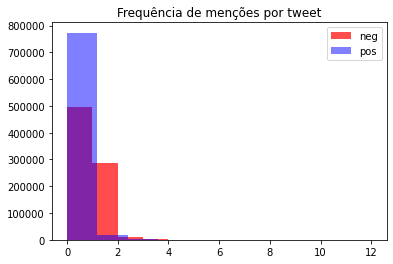

In [251]:
plt.hist(tweets_4[tweets_4['sentiment']==0]['mentions_qty'], color='red', alpha=0.7, label='neg')
plt.hist(tweets_4[tweets_4['sentiment']==4]['mentions_qty'], color='blue', alpha=0.5, label='pos')
plt.title('Frequência de menções por tweet')
plt.legend()
plt.show();

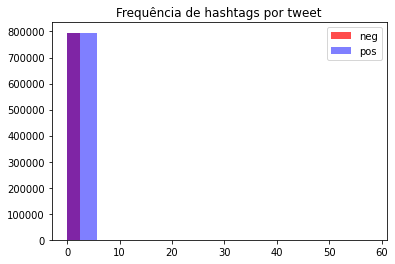

In [252]:
plt.hist(tweets_4[tweets_4['sentiment']==0]['hashtag_qty'], color='red', alpha=0.7, label='neg')
plt.hist(tweets_4[tweets_4['sentiment']==4]['hashtag_qty'], color='blue', alpha=0.5, label='pos')
plt.title('Frequência de hashtags por tweet')
plt.legend()
plt.show();

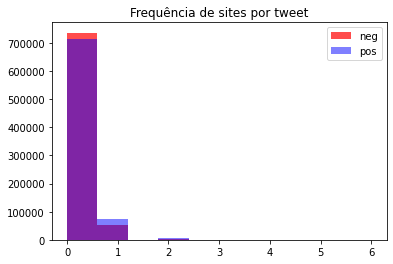

In [253]:
plt.hist(tweets_4[tweets_4['sentiment']==0]['site_qty'], color='red', alpha=0.7, label='neg')
plt.hist(tweets_4[tweets_4['sentiment']==4]['site_qty'], color='blue', alpha=0.5, label='pos')
plt.title('Frequência de sites por tweet')
plt.legend()
plt.show();

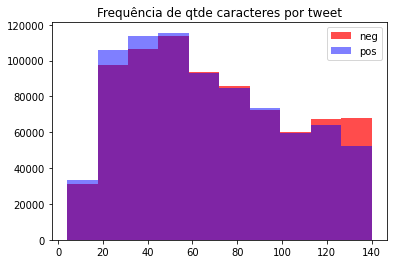

In [254]:
plt.hist(tweets_4[tweets_4['sentiment']==0]['len'], color='red', alpha=0.7, label='neg')
plt.hist(tweets_4[tweets_4['sentiment']==4]['len'], color='blue', alpha=0.5, label='pos')
plt.title('Frequência de qtde caracteres por tweet')
plt.legend()
plt.show();

In [212]:
# separando positivo de negativo ----------------------------------------------------------------------------
tweets_bad = tweets_4[tweets_4['sentiment']==0][['stem_words','stem_bigram']].reset_index(drop=True)
tweets_good = tweets_4[tweets_4['sentiment']==4][['stem_words','stem_bigram']].reset_index(drop=True)

# calculando as frequências para o STEM ---------------------------------------------------------------------
freq_all = nltk.FreqDist([x for sublist in tweets_4['stem_words'].to_list() for x in sublist])
freq_bad = nltk.FreqDist([x for sublist in tweets_bad['stem_words'].to_list() for x in sublist])
freq_good = nltk.FreqDist([x for sublist in tweets_good['stem_words'].to_list() for x in sublist])

# calculando as frequências para o STEM BIGRAM --------------------------------------------------------------
freq_all_bi = nltk.FreqDist([x for sublist in tweets_4['stem_bigram'].to_list() for x in sublist])
freq_bad_bi = nltk.FreqDist([x for sublist in tweets_bad['stem_bigram'].to_list() for x in sublist])
freq_good_bi = nltk.FreqDist([x for sublist in tweets_good['stem_bigram'].to_list() for x in sublist])

# calculando Sentiment score para as palavras ---------------------------------------------------------------
pos_neg_word_ratio = Counter()
for word, cnt in freq_all.most_common():
    pos_neg_word_ratio[word] = freq_good[word] / (freq_bad[word]+1)

# calculando Sentiment score para os bigramas ---------------------------------------------------------------
pos_neg_bigram_ratio = Counter()
for word, cnt in freq_all_bi.most_common():
    pos_neg_bigram_ratio[word] = freq_good_bi[word] / (freq_bad_bi[word]+1)

# pegando apenas os 20 elementos mais positivos de cada -----------------------------------------------------
most20_positive_words = pos_neg_word_ratio.most_common(20)
most20_positive_bigrams = pos_neg_bigram_ratio.most_common(20)

# como o score negativo fica zero, estou pegando os que tem maior frequencia na base geral ------------------
zero_word_ratio = { k:v for k,v in pos_neg_word_ratio.items() if v==0}
zero_word_freq = {k:freq_all[k] for k,v in zero_word_ratio.items()}
most20_negative_words = pd.DataFrame([zero_word_freq]).transpose()[:20]
most20_negative_words = most20_negative_words.reset_index().rename(columns={'index':'word', 0:'freq'})

zero_bigram_ratio = { k:v for k,v in pos_neg_bigram_ratio.items() if v==0}
zero_bigram_freq = {k:freq_all_bi[k] for k,v in zero_bigram_ratio.items()}
most20_negative_bigrams = pd.DataFrame([zero_bigram_freq]).transpose()[:20]
most20_negative_bigrams = most20_negative_bigrams.reset_index().rename(columns={'index':'word', 0:'freq'})

# deletando variáveis ----------------------------------------------------------------------------------------
del tweets_bad, tweets_good, freq_all, freq_all_bi, freq_bad, freq_good, freq_bad_bi, freq_good_bi
del pos_neg_word_ratio, pos_neg_bigram_ratio
del zero_word_ratio, zero_bigram_ratio, zero_word_freq, zero_bigram_freq

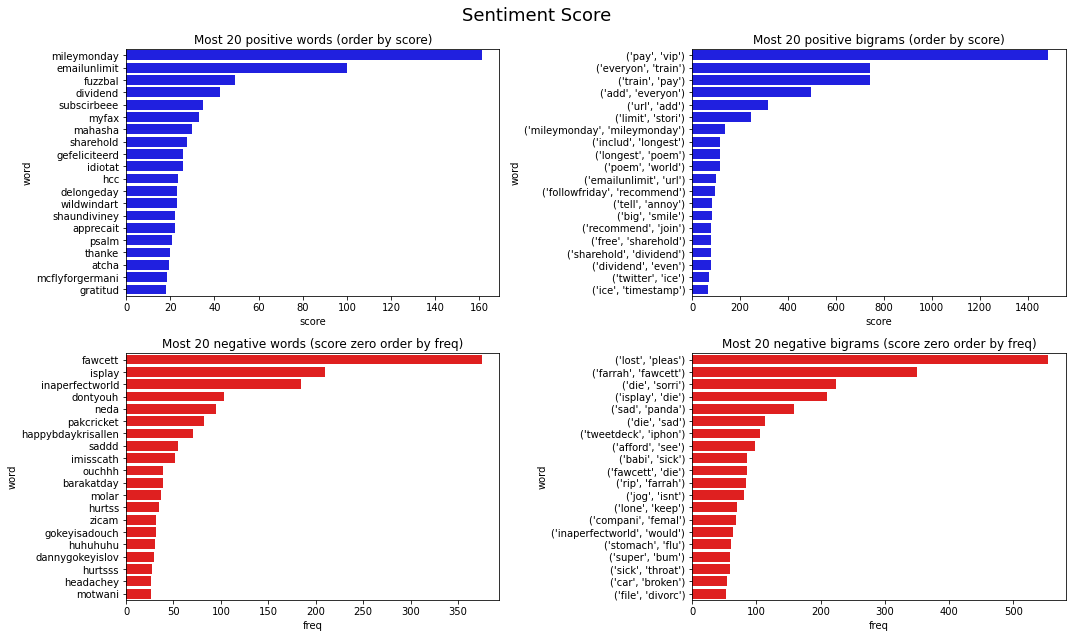

In [262]:
f, axes = plt.subplots(2, 2, figsize=(15,9)) 

temp = pd.DataFrame(most20_positive_words, columns=['word', 'score'])
sns.barplot(data=temp, y='word', x='score', color='b', ax=axes[0,0]).set_title('Most 20 positive words (order by score)')

temp = pd.DataFrame(most20_positive_bigrams, columns=['word', 'score'])
sns.barplot(data=temp, y='word', x='score', color='b', ax=axes[0,1]).set_title('Most 20 positive bigrams (order by score)')

sns.barplot(data=most20_negative_words, y='word', x='freq', color='r', ax=axes[1,0]).set_title('Most 20 negative words (score zero order by freq)')
sns.barplot(data=most20_negative_bigrams, y='word', x='freq', color='r', ax=axes[1,1]).set_title('Most 20 negative bigrams (score zero order by freq)')

f.suptitle('Sentiment Score', fontsize=18)
plt.tight_layout()
plt.show()

---  
## Construindo modelos

In [286]:
drop_cols = ['text', 'mentions_qty', 'hashtag_qty', 'site_qty', 'len',
             'tokens_with_stop', 'tokens_no_stop', 'stem_words', 'lemma_words', 
             'token_bigram','stem_bigram', 'lemma_bigram']

# filtrando apenas tweets com mais de 19 caracteres
df_model = tweets_4[tweets_4['len']>=20]
df_model = tweets_4.drop(columns=drop_cols)

In [21]:
df_model['sentiment'] = df_model['sentiment'].replace(4,1)
df_model.head()

,sentiment,token_string,stem_string,lemma_string
0,0,user url awww bummer shoulda got david carr th...,user url awww bummer shoulda got david carr th...,user url awww bummer shoulda got david carr th...
1,0,upset update facebook texting might cry result...,upset updat facebook text might cri result sch...,upset update facebook texting might cry result...
2,0,user dived many times ball managed save rest b...,user dive mani time ball manag save rest bound,user dived many time ball managed save rest bound
3,0,whole body feels itchy like fire,whole bodi feel itchi like fire,whole body feel itchy like fire
4,0,user behaving mad see,user behav mad see,user behaving mad see


In [22]:
# salvando o arquivo tratado até o momento para não precisar executar todo código na próxima vez
# df_model.to_csv('data/df_model.csv', header=True, index=False)

# carregando arquivo salvo
#df_model = pd.read_csv('data/df_model.csv')
#df_model.head()

In [23]:
#df_model.dropna(inplace=True)
df_model.isna().sum()

sentiment       0
token_string    0
stem_string     0
lemma_string    0
dtype: int64

In [24]:
df_model_sample = df_model.sample(frac=0.2, replace=False).reset_index(drop=True)

In [58]:
gscv = StratifiedKFold(n_splits=10, shuffle=True)
score = ['roc_auc', 'f1', 'accuracy']
rft = 'f1'

models = {
    'logistic':  GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('log', LogisticRegression())]), 
        param_grid={
            'log__penalty': ['l1', 'l2'],
            'log__solver': ['liblinear'],
        },
        scoring=score,
        #error_score='raise',
        refit=rft,
        cv=gscv),
    
    'tree':  GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('tree', DecisionTreeClassifier())]), 
        param_grid={
            'tree__max_depth': [5, 15],
            'tree__criterion': ['entropy', 'gini'],
        },
        scoring=score,
        refit=rft,
        cv=gscv),

    'randomforest':  GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('rf', RandomForestClassifier())]), 
        param_grid={
            'rf__max_depth': [5, 20],
            'rf__criterion': ['entropy', 'gini'],
        },
        scoring=score,
        refit=rft,
        cv=gscv),

    # 'randomforest_pca':  GridSearchCV(
    #     Pipeline([
    #         ('tfidf', TfidfVectorizer()),
    #         ('to_dense', DenseTransformer()),
    #         ('pca', PCA(n_components=50)),
    #         ('rf', RandomForestClassifier())]), 
    #     param_grid={
    #         'rf__max_depth': [5, 20],
    #         'rf__criterion': ['entropy', 'gini'],
    #     },
    #     scoring=score,
    #     refit=rft,
    #     cv=gscv),
        
    'svmrbf': GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('svm', LinearSVC())]), 
        param_grid={
            'svm__C': [1.0, 5.0],
            'svm__penalty': ['l2'],
        },
        scoring=score,
        refit=rft,
        cv=gscv),
}

---  
## Executando e Comparando os modelos

In [26]:
import warnings
warnings.filterwarnings('ignore')


== Executing model training considering column token_string  ===================================================================================================
Algorítmo treinado: logistic	 Duração: 0:01:48.461367
Algorítmo treinado: tree	 Duração: 0:06:32.404008
Algorítmo treinado: randomforest	 Duração: 0:09:15.252716
Algorítmo treinado: svmrbf	 Duração: 0:04:50.488230

Tempo total: 0:22:26.607320
>> Best Params ====================================================================================================
 > rank_test_roc_auc
   {'log__penalty': 'l2', 'log__solver': 'liblinear'}
   {'tree__criterion': 'gini', 'tree__max_depth': 15}
   {'rf__criterion': 'gini', 'rf__max_depth': 5}
   {'svm__C': 1.0, 'svm__penalty': 'l2'}

 > rank_test_f1
   {'log__penalty': 'l1', 'log__solver': 'liblinear'}
   {'tree__criterion': 'gini', 'tree__max_depth': 15}
   {'rf__criterion': 'gini', 'rf__max_depth': 5}
   {'svm__C': 1.0, 'svm__penalty': 'l2'}

 > rank_test_accuracy
   {'log__penalty': 'l

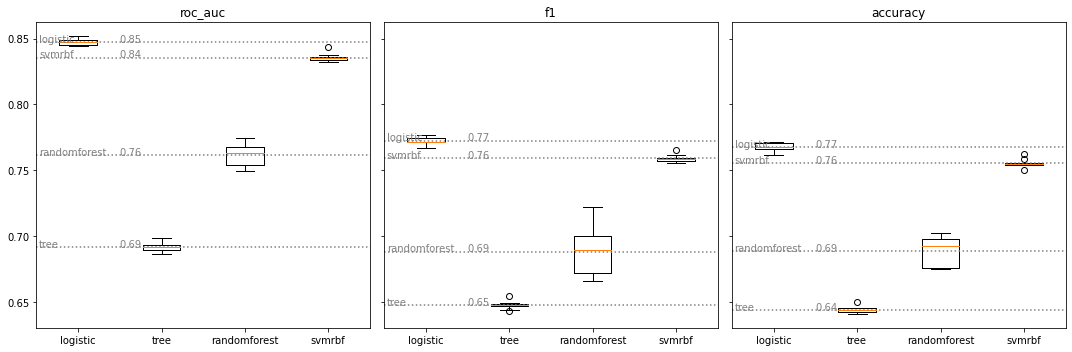


== Executing model training considering column stem_string  ===================================================================================================
Algorítmo treinado: logistic	 Duração: 0:01:47.243397
Algorítmo treinado: tree	 Duração: 0:06:20.340341
Algorítmo treinado: randomforest	 Duração: 0:09:14.617032
Algorítmo treinado: svmrbf	 Duração: 0:04:14.548998

Tempo total: 0:21:36.749768
>> Best Params ====================================================================================================
 > rank_test_roc_auc
   {'log__penalty': 'l2', 'log__solver': 'liblinear'}
   {'tree__criterion': 'gini', 'tree__max_depth': 5}
   {'rf__criterion': 'gini', 'rf__max_depth': 20}
   {'svm__C': 1.0, 'svm__penalty': 'l2'}

 > rank_test_f1
   {'log__penalty': 'l1', 'log__solver': 'liblinear'}
   {'tree__criterion': 'gini', 'tree__max_depth': 15}
   {'rf__criterion': 'gini', 'rf__max_depth': 20}
   {'svm__C': 1.0, 'svm__penalty': 'l2'}

 > rank_test_accuracy
   {'log__penalty': 'l

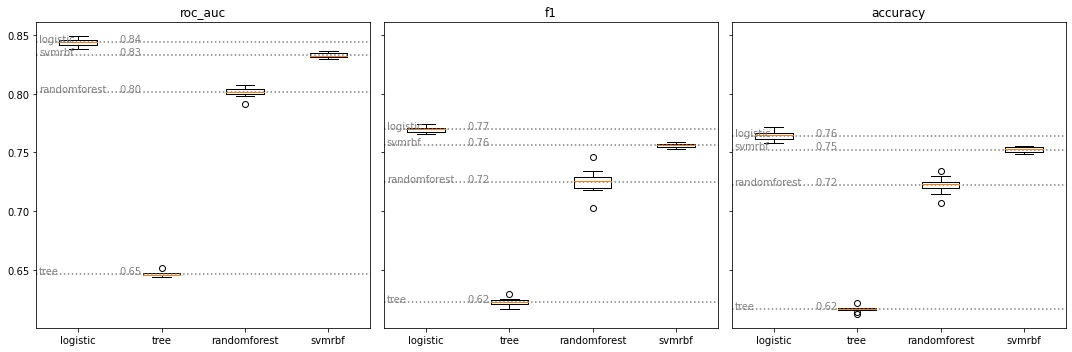


== Executing model training considering column lemma_string  ===================================================================================================
Algorítmo treinado: logistic	 Duração: 0:01:50.761055
Algorítmo treinado: tree	 Duração: 0:06:27.095830
Algorítmo treinado: randomforest	 Duração: 0:09:12.354998
Algorítmo treinado: svmrbf	 Duração: 0:04:11.430406

Tempo total: 0:21:41.642289
>> Best Params ====================================================================================================
 > rank_test_roc_auc
   {'log__penalty': 'l2', 'log__solver': 'liblinear'}
   {'tree__criterion': 'gini', 'tree__max_depth': 15}
   {'rf__criterion': 'gini', 'rf__max_depth': 20}
   {'svm__C': 1.0, 'svm__penalty': 'l2'}

 > rank_test_f1
   {'log__penalty': 'l1', 'log__solver': 'liblinear'}
   {'tree__criterion': 'gini', 'tree__max_depth': 15}
   {'rf__criterion': 'gini', 'rf__max_depth': 20}
   {'svm__C': 1.0, 'svm__penalty': 'l2'}

 > rank_test_accuracy
   {'log__penalty': 

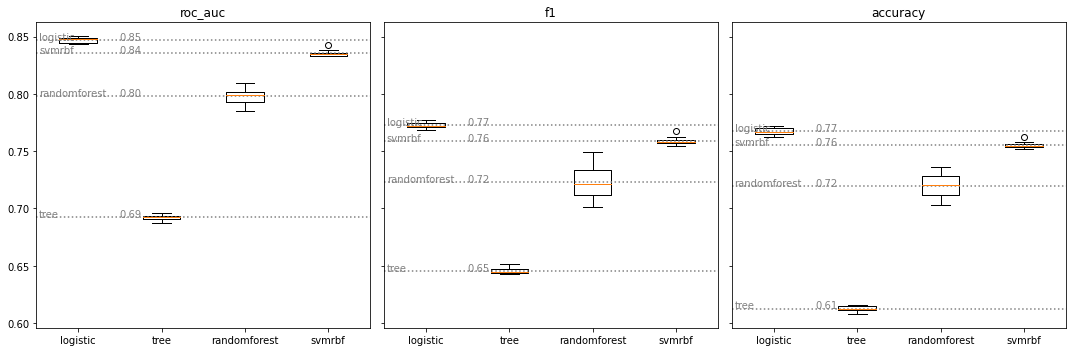

In [59]:
for col in [cols for cols in df_model_sample if 'string' in cols]:
    print('\n'+'='*160)
    print(f'== Executing model training considering column {col} ' , '='*99)   
    X = df_model_sample[col]
    y = df_model_sample['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    results = run_models_get_results(models=models, X_train=X_train, y_train=y_train)
    compare_model_score(results=results, score=score, gscv=gscv, n_models=len(models.keys()))

---  
## Backup